In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/tmb/proj/ocr2021/venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [42]:
import torch
from torch import nn

import webdataset as wds

from ocropus import ocrlayers
from torchmore import layers, flex, combos, inputstats

import pytorch_lightning as pl

# Word Dataset for Training

This code shows how to write an I/O pipeline using WebDataset.

In [32]:
def augment(sample):
    # FIXME -- provide useful augmentations for training
    return sample

In [33]:
urls = "http://storage.googleapis.com/nvdata-ocropus-words/ia1-{000000..000009}.tar"
dataset = wds.WebDataset(urls).shuffle(1000).decode("l8").rename(image="jpg;jpeg;png;word.jpg").map(augment)
sample = next(iter(dataset))
sample

{'__key__': 'foreignrelations0000unit_r8d5_0045@33',
 '__url__': 'http://storage.googleapis.com/nvdata-ocropus-words/ia1-000007.tar',
 '__worker__': 'None',
 '__rank__': 'None',
 '__nodeinfo__': "('sedna', 601996)",
 'bbox.json': [765, 690, 987, 739],
 'txt': 'reactions.',
 'image': array([[16, 17, 17, ..., 14, 15, 15],
        [16, 16, 17, ..., 15, 15, 15],
        [16, 16, 16, ..., 15, 15, 15],
        ...,
        [21, 20, 22, ..., 22, 21, 19],
        [21, 20, 22, ..., 21, 19, 17],
        [21, 20, 22, ..., 21, 19, 18]], dtype=uint8)}

'reactions.'

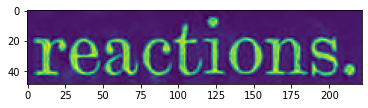

In [34]:
imshow(sample["image"])
sample["txt"]

In [38]:
def collation_fn(objects):
    # FIXME -- provide a useful collation function
    return objects

batchsize = 4
batched = dataset.to_tuple("image", "txt").batched(batchsize, collation_fn=list)
next(iter(batched))

[(array([[ 8, 11, 13, ...,  4,  3,  4],
         [10, 14, 17, ...,  4,  3,  3],
         [12, 16, 22, ...,  4,  4,  4],
         ...,
         [ 6,  6,  8, ...,  4,  4,  5],
         [ 6,  7,  7, ...,  6,  6,  7],
         [ 7,  7,  7, ..., 10, 10, 10]], dtype=uint8),
  'Recovery'),
 (array([[ 6,  6,  7, ..., 10,  9,  9],
         [ 6,  6,  6, ..., 10,  8,  8],
         [ 6,  5,  5, ..., 10,  8,  7],
         ...,
         [ 8,  8,  9, ..., 13, 10,  9],
         [ 8,  8,  8, ...,  9,  9,  8],
         [ 8,  8,  8, ...,  9,  8,  8]], dtype=uint8),
  'and'),
 (array([[ 9,  9, 12, ...,  8,  8,  8],
         [12, 13, 16, ...,  8,  8,  8],
         [18, 21, 26, ...,  9,  8,  7],
         ...,
         [11, 12, 12, ..., 13, 12, 10],
         [ 9,  9, 10, ..., 12, 11, 10],
         [ 6,  7,  8, ..., 10, 10, 10]], dtype=uint8),
  'Electronic'),
 (array([[ 6,  6,  3, ...,  6,  7,  8],
         [ 6,  6,  5, ...,  6,  7,  8],
         [ 6,  6,  6, ...,  7,  7,  8],
         ...,
         [20, 23,

Note that the batching is usually done in the dataset.

In [41]:
loader = wds.WebLoader(batched, batch_size=None)

Todo:
- write a useful collation_fn above
- optionally
    - replace .batched(64, collation_fn=...) with .then(batcher), where batcher is an iterator
    - write a useful augmentation function

# Lightning Data Module

Try to wrap up the above code in a Lightning data module. You can use the ImageNet code as an example.

https://github.com/webdataset/webdataset-lightning/blob/main/train.py

In [ ]:
class WordDataset(pl.LightningDataModule):
    
    def __init__(self, ...):
        super().__init__(self)
        ...
        
    def make_loader(self, urls, mode="train"):
        ...

# Defining a Model

This model definition uses a small library called `torchmore` that provides some layers helpful for OCR and also perform dynamic shape inference for layers.

In [7]:
noutput = 96
model = nn.Sequential(
    ocrlayers.GrayDocument(),
    *combos.conv2d_block(64, 3, mp=2, repeat=2),
    *combos.conv2d_block(96, 3, repeat=2),
    layers.Fun("lambda x: x.max(2)[0]"),
    flex.Conv1d(100, 3),
    flex.BatchNorm1d(),
    nn.ReLU(),
    layers.Reorder("BDL", "LBD"),
    flex.LSTM(100, bidirectional=True),
    layers.Reorder("LBD", "BDL"),
    flex.Conv1d(noutput, 1),
)
flex.shape_inference(model, (1, 1, 48, 300))
model(torch.zeros((1, 1, 48, 300))).shape

torch.Size([1, 96, 148])

# Lightning Module

Try to write up the model definition and training logic in a Lightning module.

You can use the Imagenet example as a starting point: https://github.com/webdataset/webdataset-lightning/blob/main/train.py

You can also reuse pieces from `ocrorec` (e.g., the CTC code): https://github.com/ocropus/ocropus4/blob/f0f4466c3371e042e9b1cc81eb118a977ea50b8c/ocropus/ocrorec.py#L101

In [ ]:
class WordRecognizer(pl.LightningModule):
    def __init__(self, learning_rate=0.1, momentum=0.9, weight_decay=1e-4, model="resnet18", **kw):
        super().__init__()
        self.save_hyperparameters()
        self.model = ...
    
    ...

# Run Training

Finally, try to run training. This means instantiating a Trainer instance can calling the `fit` method.

Have a look here at how this works in a Notebook: https://github.com/bipinKrishnan/pytorch_lightning_examples/blob/main/pytorch_lightning_cifar10.ipynb

Your code needs to do something like this:

```
trainer = pl.Trainer(max_epochs=5, gpus=1)
data = WordDataset(...)
model = WordRecognizer(...)
trainer.fit(model, data)
```